In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torchvision
from torch.autograd import Variable
import time



GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'

import multiprocessing
pool= multiprocessing.Pool(processes=(multiprocessing.cpu_count() -20))
    

num GPUs 0


# 1. Load a test image from a dataset (now : CelebA 128x128)

Dimensions of input image: (3, 128, 128)


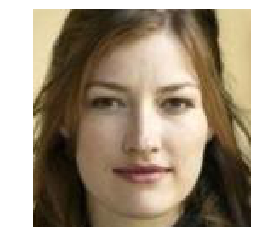

In [2]:
#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '3' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
if dataset == 'celeba':
    #img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64
    cx=89
    cy=121
    img_pil = img_pil.crop((cx-64, cy - 64, cx + 64, cy+64))

img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)


img_np_orig = 1*img_np

if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')

save_path= './extra_low_rate/Original'+'_'+img_name+'.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches = 0)

img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size

# normalize the pixels to [-1,1]
img_var = 2*img_var -1



In [3]:
f = 0.025 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)

# random Gaussian measurement process

A = torch.randn(m_image, d_image).to(device)
x = img_var.to(device).reshape(d_image)
y = torch.matmul(A,x).to(device)

#latentDim = model.config.noiseVectorDim
print(A.shape, x.shape, y.shape)
mse = torch.nn.MSELoss()

Compression rate is  0.025
Number of measurements is  1228  for signal of length  49152
torch.Size([1228, 49152]) torch.Size([49152]) torch.Size([1228])


# 2. Compressed sensing using generative models

## 2.1. Load a pretrained generative model on the dataset (now: PGGAN)

In [4]:
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)
G = model.netG
#G.eval()
latentDim = model.config.noiseVectorDim

Using cache found in /home/vanhoan310/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [5]:
#print(torch.min(img_var), torch.max(img_var))

## 2.2. CS using the loaded GAN

Running CSGM:
CSGM step 0/1600, objective = 858.60710
CSGM step 50/1600, objective = 108.36175
CSGM step 100/1600, objective = 77.54571
CSGM step 150/1600, objective = 68.51567
CSGM step 200/1600, objective = 61.44948
CSGM step 250/1600, objective = 55.89489
CSGM step 300/1600, objective = 49.05897
CSGM step 350/1600, objective = 44.78086
CSGM step 400/1600, objective = 39.08739
CSGM step 450/1600, objective = 36.58144
CSGM step 500/1600, objective = 32.85541
CSGM step 550/1600, objective = 31.32629
CSGM step 600/1600, objective = 30.07155
CSGM step 650/1600, objective = 30.14003
CSGM step 700/1600, objective = 28.31019
CSGM step 750/1600, objective = 27.23781
CSGM step 800/1600, objective = 26.74793
CSGM step 850/1600, objective = 25.84782
CSGM step 900/1600, objective = 25.96223
CSGM step 950/1600, objective = 24.88573
CSGM step 1000/1600, objective = 28.34177
CSGM step 1050/1600, objective = 24.00333
CSGM step 1100/1600, objective = 24.14458
CSGM step 1150/1600, objective = 23.59701

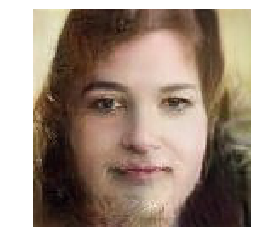

In [6]:
t0= time.time()

z_hat, mse_wrt_loss = CSGM2(G, latentDim, y, A, device, num_iter = 1600)
x_hat = G(z_hat)

grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.axis('off')
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

save_path= './extra_low_rate/PGGAN'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0) 
    
t1= time.time()
print('\nTime elapsed:',t1-t0)

error_wrt_truth = mse(x_hat, img_var).item()
print('\nl2-recovery error:', error_wrt_truth)

In [7]:
'''plt.xlabel('optimizer iteration')
plt.ylabel('recovery error')
plt.semilogy(mse_wrt_truth)'''

"plt.xlabel('optimizer iteration')\nplt.ylabel('recovery error')\nplt.semilogy(mse_wrt_truth)"

# 3. Compressed Sensing using Deep decoder

## 3.1. Define the network

In [8]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample

num_channels = [120,40,20,15,10] 

output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)



n_scales= 5 num_channels_up= [120, 40, 20, 15, 10]
number of parameters:  13110
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(120, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(20, 15, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu2): ReLU()
  (dbn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups2): Upsample(scale_factor=2.0, mode=bilinear)
  (dcon

## 3.2. CS using untrained network

shape of latent code B1:  [1, 120, 8, 8]
initializing latent code B1...

Learning rate is set to 0.001


Iteration 00000   Train loss 470.030050 
Iteration 00100   Train loss 50.989161 
Iteration 00200   Train loss 29.367776 
Iteration 00300   Train loss 19.379025 
Iteration 00400   Train loss 13.236421 
Iteration 00500   Train loss 9.904642 
Iteration 00600   Train loss 8.264626 
Iteration 00700   Train loss 7.529783 
Iteration 00800   Train loss 5.918512 
Iteration 00900   Train loss 5.331823 
Iteration 01000   Train loss 4.907495 
Iteration 01100   Train loss 4.605637 
Iteration 01200   Train loss 3.904263 
Iteration 01300   Train loss 3.732278 
Iteration 01400   Train loss 3.392989 
Iteration 01500   Train loss 3.361414 
Iteration 01600   Train loss 3.188301 
Iteration 01700   Train loss 2.922016 
Iteration 01800   Train loss 2.794719 
Iteration 01900   Train loss 2.665688 
Iteration 02000   Train loss 2.598917 
Iteration 02100   Train loss 2.495892 
Iteration 02200   Train loss 2.

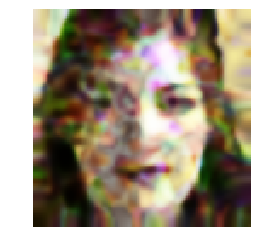

In [9]:
t0 = time.time()

net, net_input, loss = CS_DD(net, num_channels, d_image, y=y, A=A, device= device, 
                             num_iter = 12000, lr_decay_epoch=3000)
x_hat = net( net_input.type(dtype) )#.data.cpu().numpy()[0]

t1 = time.time()
grid = torchvision.utils.make_grid(x_hat, scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
#plt.imshow(x_hat.transpose(1,2,0))
#plt.show()

print('\n time elapsed:', t1-t0)

error_wrt_truth = mse(x_hat, img_var).item()
print('\nl2-recovery error:', error_wrt_truth)

save_path= './extra_low_rate/DD'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0)


# 4. Compressed sensing using hybrid model

## 4.1. Define the untrained network used for hybrid model

In [10]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample

num_channels = [120,40,20,15,10] 

output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)

n_scales= 5 num_channels_up= [120, 40, 20, 15, 10]
number of parameters:  13110
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(120, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(20, 15, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu2): ReLU()
  (dbn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups2): Upsample(scale_factor=2.0, mode=bilinear)
  (dcon

## 4.2. CS using hybrid model

Running CSGM:
CSGM step 0/600, objective = 661.66128
CSGM step 50/600, objective = 87.95806
CSGM step 100/600, objective = 52.82461
CSGM step 150/600, objective = 38.86211
CSGM step 200/600, objective = 33.17290
CSGM step 250/600, objective = 30.23965
CSGM step 300/600, objective = 28.75662
CSGM step 350/600, objective = 27.27838
CSGM step 400/600, objective = 26.90150
CSGM step 450/600, objective = 26.01341
CSGM step 500/600, objective = 23.99447
CSGM step 550/600, objective = 25.13031
shape of latent code B1:  [1, 120, 8, 8]
initializing latent code B1...
Iteration 0000   Train loss 419.481501 
Iteration 0100   Train loss 38.399978 
Iteration 0200   Train loss 23.913368 
Iteration 0300   Train loss 18.213299 
Iteration 0400   Train loss 14.547876 
Iteration 0500   Train loss 11.914608 
Iteration 0600   Train loss 9.597501 
Iteration 0700   Train loss 8.333615 
Iteration 0800   Train loss 7.433713 
Iteration 0900   Train loss 6.552271 
tensor([1.0070], requires_grad=True) tensor([0.79

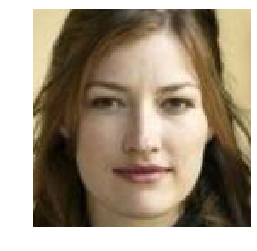

In [11]:
t0 = time.time()
z0, mse_wrt_truth = CSGM2(G=G, latentDim=latentDim, y=y, A=A, device=device, num_iter=600)

x0 = G(z0)

#grid = torchvision.utils.make_grid(x0.clamp(min=-1, max=1), scale_each=True, normalize=True)
#plt.axis('off')
#plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

net, net_input, z, alpha, beta, loss = CS_hybrid(G, net, num_channels, d_image, y, A, z_0 = z0, 
                                            latentDim=latentDim, num_iter = 1000, lr_decay_epoch = 0)

x_hat = alpha.clamp(0,1)*G(z) + beta.clamp(0,1)*(2*net(net_input.type(dtype)) - 1)

print(alpha,beta)

grid = torchvision.utils.make_grid(img_var, scale_each=True, normalize=True)
plt.axis('off')
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

t1 = time.time()
print('\n time elapsed:', t1-t0)

error_wrt_truth = mse(x_hat, img_var)
print('\nl2-recovery error:', error_wrt_truth)


save_path= './extra_low_rate/Hybrid'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0) 